# Рекомендация тарифов

В нашем распоряжении уже предобработанные данные о поведении клиентов, использующих разные тарифы (из проекта «Определение перспективного тарифа для телеком-компании»). Необходимо выстроить модель классификации, которая будет рекомендовать клиенту подходящий тариф.

Задача - построить модель с максимально большим значением *accuracy*. Требуется довести долю правильных ответов на тестовой выборке по крайней мере до 0.75.

**Предоставленные данные:**
- данные о поведении клиентов, уже использующих новые тарифы. Предобработка данных уже проведена.

**Этапы работы:**
1. Обзор предоставленных данных.
2. Выделение обучающей, валидационной и тестовой выборок.
3. Исследование качества разных моделей, подбор гиперпараметров.
4. Проверка качества модели на тестовой выборке.
5. Проверка модели на вменяемость.

**Цель работы:**

Построение модели для задачи классификации, способной предложить клиентам пододящий тариф на основе данных об их поведении.

**Используемые библиотеки:**

- Pandas
- Scikit-learn
- Matplotlib
- Seaborn
- XGBoost
- tqdm

<h1>Содержание:<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Выделение-выборок" data-toc-modified-id="Выделение-выборок-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Выделение выборок</a></span></li><li><span><a href="#Исследование-моделей" data-toc-modified-id="Исследование-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование моделей</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Градиентный-бустинг" data-toc-modified-id="Градиентный-бустинг-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Градиентный бустинг</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Проверка-моделей-на-тестовой-выборке-и-общий-вывод" data-toc-modified-id="Проверка-моделей-на-тестовой-выборке-и-общий-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка моделей на тестовой выборке и общий вывод</a></span></li><li><span><a href="#Проверка-моделей-на-адекватность" data-toc-modified-id="Проверка-моделей-на-адекватность-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Проверка моделей на адекватность</a></span></li></ul></div>

## Обзор данных

In [1]:
# Импортируем необходимые модули:
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn import base, tree
from sklearn.utils import resample

from xgboost import XGBClassifier

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

Ознакомимся с общей информацией и выборкой из таблицы:

In [2]:
df = pd.read_csv('users_behavior.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [3]:
# Здесь и далее мы будем использовать постоянный random seed для воспроизведения результатов:
random_state = 177013
df.sample(n=10, random_state=random_state)

,calls,minutes,messages,mb_used,is_ultra
3091,17.0,91.03,13.0,2614.07,1
1651,58.0,408.53,2.0,15346.04,0
2747,43.0,343.32,20.0,6377.68,0
2306,54.0,366.17,59.0,19497.32,0
3104,81.0,509.52,40.0,27210.40,1
3189,46.0,329.61,42.0,13249.14,0
2132,18.0,117.80,0.0,10006.79,1
1767,50.0,375.76,78.0,12666.67,1
65,98.0,677.18,46.0,16285.67,0
1379,77.0,480.37,33.0,20586.08,0


Хотя данные уже оговорены как предобработанные, на всякий случай проверим их на дубликаты и пропущенные значения в столбцах:

In [4]:
df.duplicated().sum()

0

In [5]:
df.isnull().mean()

calls       0.0
minutes     0.0
messages    0.0
mb_used     0.0
is_ultra    0.0
dtype: float64

### Вывод

Предоставлены данных о 3214 клиентах по 5 признакам (в том числе 4 числовым и 1 категориальному). Предобработка данных выглядит удовлетворительной: явных дубликатов и пропусков нет. Использование вещественных чисел вместо целых в сочетании с sklearn выглядит даже предпочтительней, бинарный признак для тарифа - еще лучше.

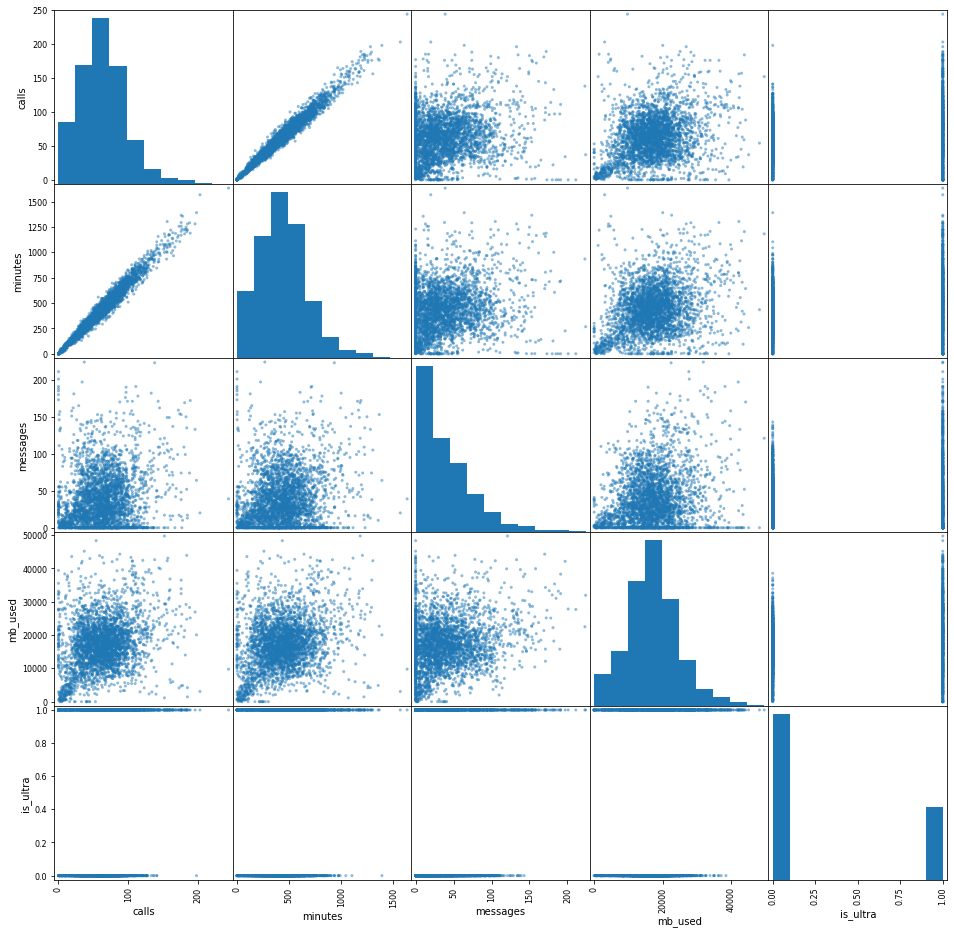

In [6]:
pd.plotting.scatter_matrix(df, figsize=(16,16));

Минуты и число звонков зависят почти линейно, с очень небольшим разбросом. Другие факторы не показывают такой четкой зависимости, но на всякий случай проверим корреляцию:

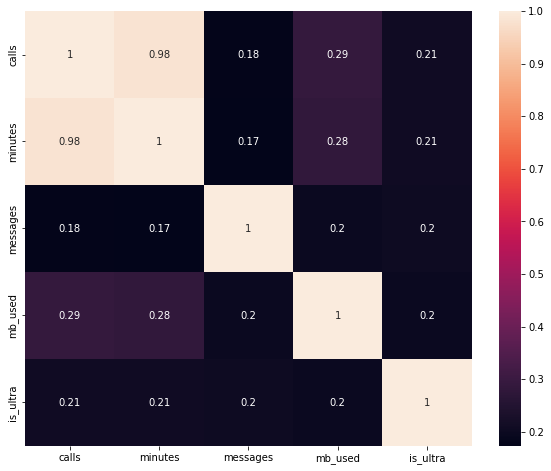

In [7]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True);

Действительно, корреляция числа разговоров и минут 0,98! Избавиться от одного из столбцов вполне разумно. Остальные признаки показывают низкий коэффициент, так что это говорит лишь о том, что активные пользователи одной из услуг могут активнее использовать и другие, но далеко не всегда.

In [8]:
df = df.drop('calls', axis=1)

## Выделение выборок

Впрочем, есть момент, о котором предобработка не позаботилась: датасет не сбалансирован:

In [9]:
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

69% пользователей используют тариф *smart*, иными словами, всегда выбирая этот ответ, мы бы получили 69% точности предсказаний. Модели, обученные на таком распределении, показали бы удовлетворительную точность в среднем, но для каждого тарифа точность сильно отличалась бы.

Поправить дело нам поможет *sklearn.utils.resample()*:

In [10]:
df_train = df.sample(frac=0.6, random_state=random_state)
df_valid = df[~df.index.isin(df_train.index)]
df_train.shape

(1928, 4)

In [11]:
df_train.shape[0] + df_valid.shape[0]

3214

Мы выделим 60% данных для обучения и по 20% для валидации и тестирования, но при этом сбалансируем классы в обучающем наборе, тем самым увеличив его:

In [12]:
df_smart = df_train[df_train['is_ultra']==0]
df_ultra = df_train[df_train['is_ultra']==1]

smart_len = len (df_smart)

df_ultra_oversample = resample(df_ultra, replace=True, n_samples=len(df_smart), random_state=random_state)

df_train = pd.concat([df_smart, df_ultra_oversample])

df_train['is_ultra'].value_counts()

0    1323
1    1323
Name: is_ultra, dtype: int64

Теперь отделим целевой признак от остальных и создадим обучающую, проверочную и тестовую выборки на базе этих двух наборов:

In [13]:
features_train = df_train.drop('is_ultra', axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop('is_ultra', axis=1)
target_valid = df_valid['is_ultra']

In [14]:
%%script echo (Если вы хотите проверить работу моделей без балансировки обучающей выборки, закомментируйте эту строку.)
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=random_state)

Couldn't find program: 'echo'


In [15]:
# Выделим тестовую выборку:
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=random_state)

## Исследование моделей

### Логистическая регрессия

Начнем с самого простого и быстрого метода: логистической регрессии.

In [16]:
def print_hyps(model):
    global best_score
    print(f'Класс: {type(model)}')
    if hasattr(model,'solver'):
        print(f'Метод: {model.solver}')
    if hasattr(model,'max_depth'):
        print(f'Предел высоты: {model.max_depth}')
    if hasattr(model,'min_samples_leaf'):
        print(f'Минимальный размер узла: {model.min_samples_leaf}')
    if hasattr(model,'n_estimators'):
        print(f'Количество деревьев: {model.n_estimators}')
    print(f'Качество: {best_score:.0%}')

In [17]:
best_logres = None
best_score = 0

# newton-cg и sag/saga не очень сходятся:
for solver in ['lbfgs', 'liblinear']:
    model = LogisticRegression(random_state=random_state, solver=solver)
    model.fit(features_train, target_train)
    score = model.score(features_valid, target_valid)
    if score > best_score:
        best_score = score
        best_logres = model

In [18]:
print_hyps(best_logres)

Класс: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Метод: lbfgs
Качество: 65%


Всего лишь <font color='purple'>65%</font> на валидации. Отметим, что для несбалансированного датасета средний результат был бы на первый взгляд лучше - около 75%, но это достигалось бы за счет совершенно неприемлемой точности на тарифе *ultra*.

### Дерево решений

Для дерева решений мы попробуем подобрать оптимальные гиперпараметры `max_depth` (высота дерева) и `min_samples_leaf` (минимальный размер "листа", то есть конечного узла, позволяющий уменьшить сложность дерева):

In [19]:
best_tree = None
best_score = 0

for depth in tqdm(range(1, 10)):
    for samples in range(1,5):
        model = DecisionTreeClassifier(random_state=random_state, max_depth=depth, min_samples_leaf=samples)
        model.fit(features_train, target_train)
        score = model.score(features_valid,target_valid)
        if score > best_score:
            best_score = score
            best_tree = model

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 43.18it/s]


In [20]:
print_hyps(best_tree)

Класс: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Предел высоты: 3
Минимальный размер узла: 1
Качество: 79%


Оптимизация позволила нам достичь точности в 79%, дальнейшее увеличение высоты показывает себя нецелесообразным.

Кроме того, модель легко наглядно визуализировать, что тоже плюс.

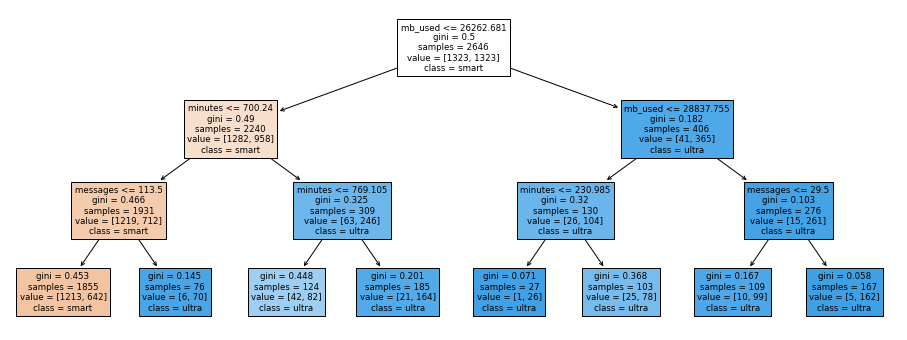

In [21]:
plt.figure(figsize=(16,6))
tree.plot_tree(best_tree, feature_names=features_train.columns, class_names=['smart','ultra'],filled=True);

### Случайный лес

У Random Forest есть несколько гиперпараметров, которые могут помочь нам улучшить качество модели, хотя подбор займет некоторое время:

In [22]:
best_forest = None
best_score = 0

for est in tqdm(range(1,10)):
    for depth in range(1,10):
        for samples in range(1,5):
            model = RandomForestClassifier(random_state=random_state, max_depth=depth, min_samples_leaf=samples, n_estimators=est)
            model.fit(features_train, target_train)
            score = model.score(features_valid,target_valid)
            if score > best_score:
                best_score = score
                best_forest = model

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.96it/s]


In [23]:
print_hyps(best_forest)

Класс: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Предел высоты: 6
Минимальный размер узла: 1
Количество деревьев: 3
Качество: 80%


80% попаданий на валидации, качество растет.

### Градиентный бустинг

Результаты уже можно считать приемлемыми, но для полноты картины попробуем применить очень модную библиотеку XGBoost, реализующую метод градиентного бустинга деревьев. Говоря проще, в отличие от Random Forest, здесь "деревья" будут выращиваться последовательно, и новое будет улучшать результат предыдущего:

In [28]:
best_xgboost = None
best_score = 0

for est in tqdm(range(1,70)):
    for depth in range(1, 10):
            model = XGBClassifier(max_depth=depth, random_state=random_state, n_estimators=est, use_label_encoder=False, eval_metric='logloss')
            model.fit(features_train, target_train)
            score = model.score(features_valid,target_valid)
            if score > best_score:
                best_score = score
                best_xgboost = model

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:36<00:00,  1.90it/s]


In [25]:
print_hyps(best_xgboost)

Класс: <class 'xgboost.sklearn.XGBClassifier'>
Предел высоты: 1
Количество деревьев: 20
Качество: 80%


### Вывод

Результаты валидации можно назвать ожидаемыми:
- Логистическая регрессия, как самый быстрый вариант с минимумом параметров и настроек, показывает точность предсказаний около 65%. Это нельзя признать достаточным для поставленой задачи.
- Дерево решений показывает более надежный результат: до 79% с подбором предела глубины, подбор размера "листа" не вносит существенного эффекта.
- Случайный лес, ценой перебора числа деревьев, глубины и размера узла, достигает точности 80% на валидации.
- Модный метод градиентного бустинга, также с перебором высоты и числа деревьев, выдает такой же результат (80%).

## Проверка моделей на тестовой выборке и общий вывод

In [29]:
model_list = [best_logres, best_tree, best_forest, best_xgboost]
name_list = ['Логистическая регрессия', 'Дерево решений', 'Случайный лес', 'Градиентный бустинг']
for model, name in zip(model_list, name_list):
    score = model.score(features_test, target_test)
    print (f'{name}: качество {score:.0%}')

Логистическая регрессия: качество 65%
Дерево решений: качество 81%
Случайный лес: качество 79%
Градиентный бустинг: качество 80%


Тестирование подтверждает тенденции, выявленные на валидации:
- Модель **логистической регрессии** с выявленной достоверностью предсказаний 65% нельзя считать подходящей для поставленной задачи: ее качество явно ниже допустимого предела.
- Модель **дерева решений** с достоверностью 79-81% может быть принята как допустимый вариант, если есть ограничения по быстродействию.
- **Случайный лес** при условии отсутствия ограничений по машинному времени (в том числе на подбор оптимальных гиперпараметров) показывает как минимум не худший результат - до 80%
- **XGBoost** тоже выглядит неплохо с качеством также около 80%, дальнейшая оптимизация гиперпараметров возможна, но в рамках формата тетради выглядит слишком времязатратной. Предпочтительнее использовать для этого специализированные библиотеки наподобие *hyperopt*.

## Проверка моделей на адекватность

Проведем дополнительное тестирование на три критерия:
- Сходятся ли модели в целом (точность на обучающей выборке).
- Действительно ли модели лучше фиктивных методов?
- Сравнима ли точность предсказаний на обоих тарифах?

In [31]:
for model, name in zip(model_list, name_list):
    score = model.score(features_train, target_train)
    print (f'{name}: качество {score:.0%}')

Логистическая регрессия: качество 63%
Дерево решений: качество 72%
Случайный лес: качество 76%
Градиентный бустинг: качество 74%


Сходимость логистической регрессии, как видим, не слишком хороша (методы, отличные от lbfgs и liblinear работают еще хуже). Остальные модели сходятся заметно лучше, особенно Random Forest, но не показывают тенденции к переобучению.

Что касается второго критерия, sklearn предоставляет нам dummy classifier, использующий несколько фиктивных методов (случайный выбор, выбор только самого частого значения признака и т.д.). Посмотрим, не зря ли мы обучали наши модели:

In [32]:
for strategy in ['uniform','most_frequent','stratified','prior']:
    dummy = DummyClassifier(strategy=strategy, random_state=random_state)
    dummy.fit(features_train, target_train)
    dummy_accuracy = dummy.score(features_test, target_test)
    print(f'Стратегия: {strategy}, точность предсказаний {dummy_accuracy:.0%}.')

Стратегия: uniform, точность предсказаний 52%.
Стратегия: most_frequent, точность предсказаний 71%.
Стратегия: stratified, точность предсказаний 50%.
Стратегия: prior, точность предсказаний 71%.


Следование самому частому значению, как видим, не так уж и плохо, ведь около 70% клиентов используют тариф *smart*. Наши модели, за исключением логистической регрессии, в среднем работают лучше. А как насчет сравнения качества моделей на разных тарифах?

In [33]:
for model, name in zip(model_list, name_list):
    predictions = model.predict(features_test)
    ultra_correct=0
    ultra_count=0
    smart_correct=0
    smart_count=0
    for prediction, target in zip (predictions, target_test):
        if target == 1:
            ultra_count+=1
            if prediction == target:
                ultra_correct+=1
        else:
            smart_count+=1
            if prediction == target:
                smart_correct+=1
    print(f'{name}: ultra {ultra_correct/ultra_count:.0%}, smart {smart_correct/smart_count:.0%}')

Логистическая регрессия: ultra 56%, smart 69%
Дерево решений: ultra 52%, smart 92%
Случайный лес: ultra 58%, smart 88%
Градиентный бустинг: ultra 59%, smart 89%


Точность на тарифе *ultra*, к сожалению, все еще недостаточно хороша, но для сравнения приведем цифры, которые мы получили бы при обучении на несбалансированном датасете:

- Логистическая регрессия: ultra 21%, smart 98%
- Дерево решений: ultra 44%, smart 95%
- Случайный лес: ultra 47%, smart 92%
- Градиентный бустинг: ultra 47%, smart 94%

Вне зависимости от поставленных условий, случайный лес и градиентный бустинг выглядят лучшими вариантами, дерево решений достойно рассмотрения, когда важнее быстродействие.